# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [3]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('../../../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [4]:
# Install keras
!pip install -U keras

Requirement already up-to-date: keras in c:\apps\lib\site-packages (2.4.3)


In [15]:
!pip install -U tensorflow

  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [6]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer)

In [10]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
# What do these sequences look like?
X_train_seq[0]

[544,
 279,
 1246,
 16,
 22,
 3830,
 34,
 1095,
 203,
 213,
 1096,
 627,
 405,
 353,
 1247,
 1248,
 1249,
 1250,
 1097,
 9,
 4,
 545,
 374,
 16]

In [11]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [12]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   24,  267,  133,  235, 3883, 2609, 3884, 3885, 3886, 3887,
        611, 1664,    7, 3888, 1120, 3889])

### Build Model

In [13]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [14]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          255424    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 264,833
Trainable params: 264,833
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [16]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 8s 55ms/step - loss: 0.2568 - accuracy: 0.9188 - precision_m: 0.5057 - recall_m: 0.4183 - val_loss: 0.0477 - val_accuracy: 0.9865 - val_precision_m: 0.9810 - val_recall_m: 0.9125
Epoch 2/10
140/140 [==============================] - 6s 40ms/step - loss: 0.0352 - accuracy: 0.9899 - precision_m: 0.9771 - recall_m: 0.9513 - val_loss: 0.0336 - val_accuracy: 0.9928 - val_precision_m: 0.9833 - val_recall_m: 0.9604
Epoch 3/10
140/140 [==============================] - 3s 23ms/step - loss: 0.0138 - accuracy: 0.9962 - precision_m: 0.9778 - recall_m: 0.9652 - val_loss: 0.0341 - val_accuracy: 0.9937 - val_precision_m: 0.9833 - val_recall_m: 0.9640
Epoch 4/10
140/140 [==============================] - 3s 23ms/step - loss: 0.0060 - accuracy: 0.9989 - precision_m: 0.9991 - recall_m: 0.9954 - val_loss: 0.0312 - val_accuracy: 0.9946 - val_precision_m: 1.0000 - val_recall_m: 0.9604oss: 0.0034 - accuracy: 0.9993 - precision_m: 1.0000 - 
Epoch 5/10
14

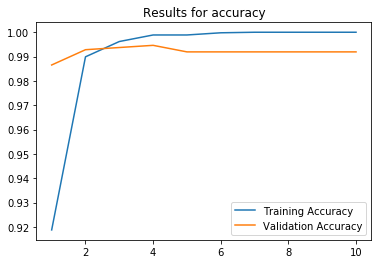

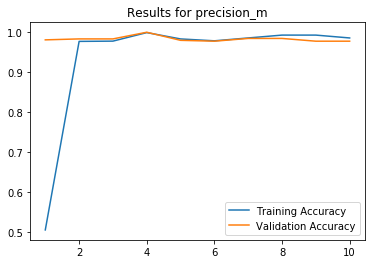

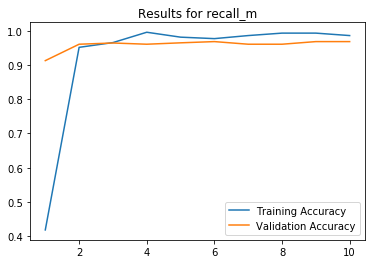

In [17]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()